In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import math

In [2]:
x,y,yerr,ignore = np.loadtxt('fgas_spt.txt', unpack=True)

<ErrorbarContainer object of 3 artists>

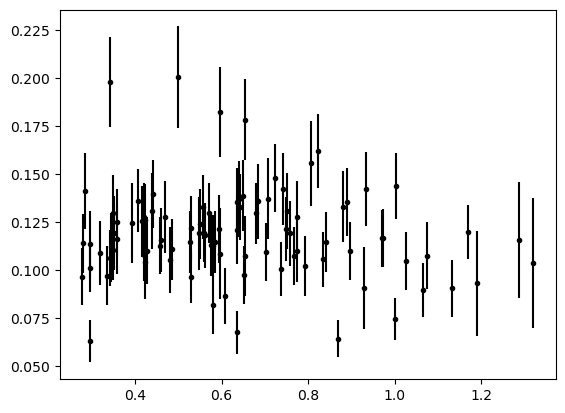

In [3]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

Least-squares estimates:
m = -0.009 ± 0.007
b = 0.119 ± 0.005


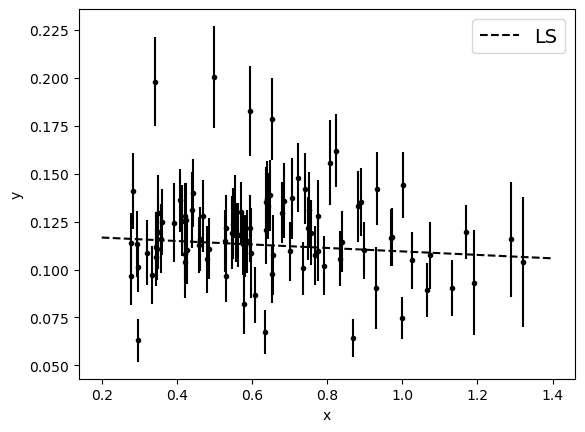

In [4]:
x0 = np.linspace(0.2, 1.4, 500)
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)

plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
#plt.ylim(0,0.8)
plt.xlabel("x")
plt.ylabel("y");

In [5]:
m_ini = w[0]
b_ini = w[1]
log_int_ini=1

In [6]:
print(m_ini)
print(b_ini)
print(log_int_ini)

-0.009045252868222059
0.11850231882072948
1


In [7]:
f0_ini=b_ini
f1_ini=m_ini/b_ini

In [8]:
print(f1_ini)
print(f0_ini)

-0.0763297542042678
0.11850231882072948


In [9]:
def log_likelihood(theta, x, y, yerr):
    f1,f0, log_int = theta
    model = f0*f1 * x + f0
    m=f0*f1
    sigmax=0
    sigma2 = yerr**2 + m**2 *sigmax**2  +np.exp(2 * log_int)


    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

Maximum likelihood estimates:
f1 = -0.068
f0 = 0.121
int = 0.016


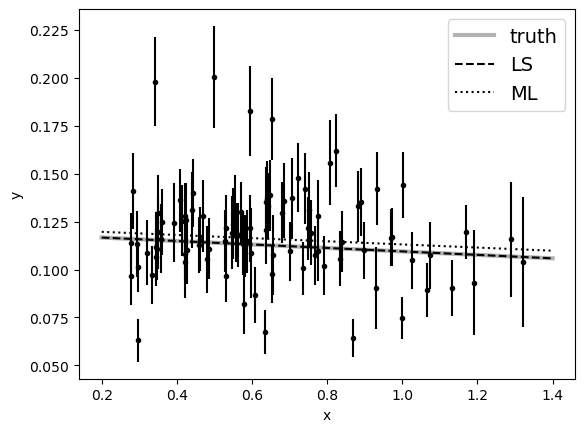

In [10]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([f1_ini, f0_ini, log_int_ini])
soln = minimize(nll, initial, args=(x, y, yerr))
f1_ml, f0_ml, log_int_ml = soln.x

print("Maximum likelihood estimates:")
print("f1 = {0:.3f}".format(f1_ml))
print("f0 = {0:.3f}".format(f0_ml))
print("int = {0:.3f}".format(np.exp(log_int_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, f1_ini*f0_ini * x0 + f0_ini, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [f1_ml*f0_ml, f0_ml]), ":k", label="ML")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
#plt.ylim(0,0.8)
plt.xlabel("x")
plt.ylabel("y");

In [11]:
def log_prior(theta):
    f1,f0 ,log_int = theta
    if -0.5 < f1 < 0.5 and 0.0 < f0 < 0.5 and -5 < log_int < 1.0:
        return 0.0
    return -np.inf

In [12]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [13]:
import emcee

pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 289.65it/s]


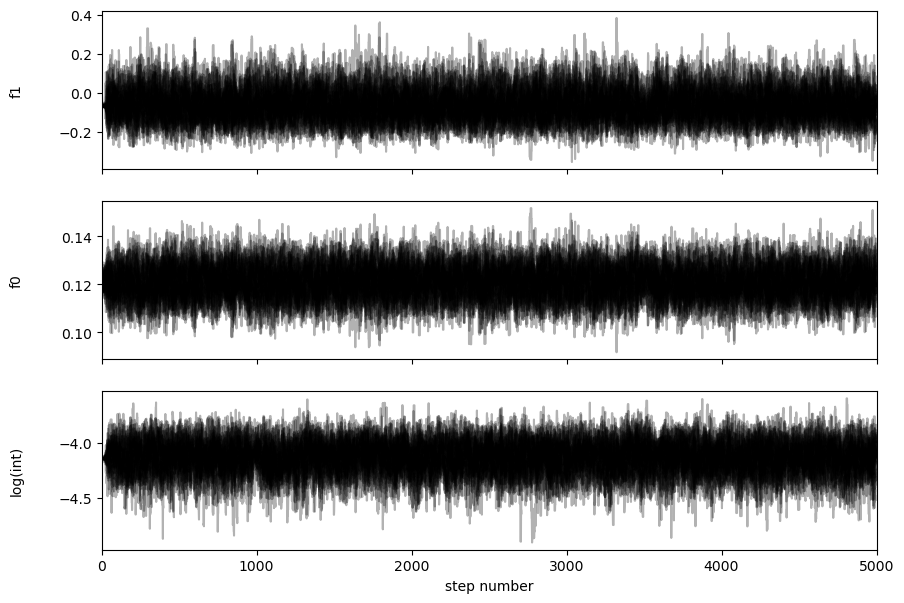

In [14]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["f1", "f0", "log(int)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [15]:
tau = sampler.get_autocorr_time()
print(tau)

[36.95892167 35.6198681  40.19754764]


In [16]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


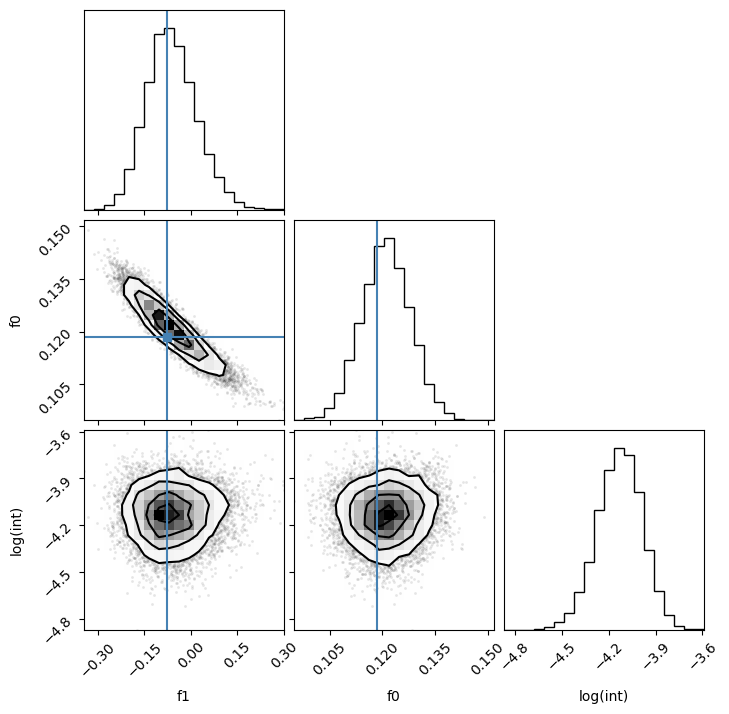

In [17]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[f1_ini, f0_ini, np.log(log_int_ini)]
);

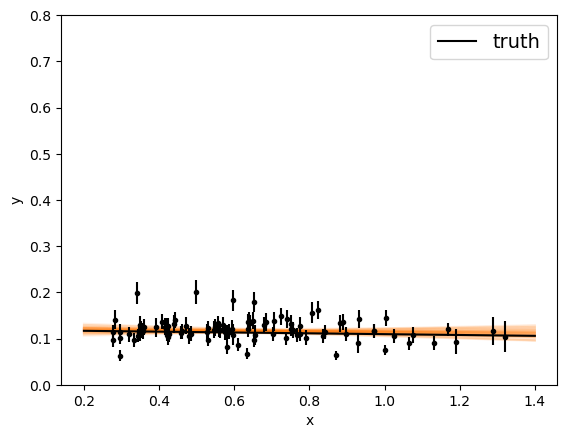

In [18]:
inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), np.array([sample[0]*sample[1],sample[1]])), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, f1_ini *f0_ini* x0 + f0_ini, "k", label="truth")
plt.legend(fontsize=14)
#plt.xlim(0, 10)
plt.ylim(0,0.8)
plt.xlabel("x")
plt.ylabel("y");

In [19]:
from IPython.display import display, Math
ndim=2
print("f1 and f0 value at 68 percentile")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [0,68,0])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

f1 and f0 value at 68 percentile


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [20]:
from IPython.display import display, Math
ndim=2
print("f1 and f0 value at 90 percentile")
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [0,90,0])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

f1 and f0 value at 90 percentile


<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [21]:
print(f1_ini)
print(f0_ini)

-0.0763297542042678
0.11850231882072948
